In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import yaml

In [15]:
from catboost import CatBoostRegressor
from catboost import Pool
from sklearn.model_selection import  train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    matthews_corrcoef,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import shap
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

In [16]:
def score_regression_simple(target, predictions,) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)

    metrics = {
        "R2":       round(r2_score(target, predictions),3),
        "MAE":  round(mean_absolute_error(target, predictions),3),
        "MSE":  round(mean_squared_error(target, predictions),3),
        "RMSE":   round((np.sqrt(mean_squared_error(target, predictions))),3),
        "MAPE":        round(mean_absolute_percentage_error(target, predictions),3),
        } 
    return metrics

In [17]:
def calc_min_price_rolling(data, delta_h=24, features=None):
    if features is None:
        features = ['rarity', 'genesis', 'sneaker_type', 'level', 'mint']

    result = np.zeros(len(data))

    for i in range(len(data)):
        #i = 156
        sample = data.iloc[i]
        data_tmp = data.iloc[:i]
        data_tmp = data_tmp[data_tmp['date'] > (sample['date'] - pd.Timedelta(delta_h, unit='h'))]

        for feature in features:
            data_tmp = data_tmp[(data_tmp[feature] == sample[feature])]
        result[i] = data_tmp['price'].min()
    
    return result

In [18]:
!pip freeze > requirements.txt

# SETUP

In [19]:
CONFIG_DIR = '../app/'

In [20]:
with open(f"{CONFIG_DIR}config_prod.yml", 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.SafeLoader)

In [21]:
BD_NAME = f'{config["DATASET"]}.csv'
BD_FOLDER = './data'
VERSION = config["VERSION"]
START_DATE = '2022-09-03'
TETS_DATE = '2022-09-17'

In [22]:
data_quality_expected_range_dict = {
    'sneaker':
        {
        #'is_type': {'genesis': bool},
        'is_in':
            {
            'rarity': ['common', 'uncommon', 'rare'],
            'sneaker_type': ['ranger', 'sprinter', 'hiker', 'coacher'],
            },
        'min_max':
            {
            'level': [0, 30],
            'base_performance': [0, 40],
            'base_fortune': [0, 40],
            'base_joy': [0, 40],
            'base_durability': [0, 40],
            'performance': [0, 500],
            'fortune': [0, 300],
            'joy': [0, 300],
            'durability': [0, 300],
            'mint': [0, 7],
            'buy_count_12H': [0, 500],
            'buy_count_24H': [0, 1000],
            'sell_count_24H': [0, 2000],
            'cancel_count_24H': [0, 1000],
            'token_all_activity_3H': [0, 30],
            'token_sell_activity_6H': [0, 30],
            },
        }
}

# DATA

In [23]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
0,1663783185,35996,53122,sell,0xb461fabc81689d05df757fbf91ae3825ed6f71f4,NaN,1.68,sneakers,common,coacher,...,439.0,8281.0,27345,4420,441,3216,6145,10618,89.0,1.216590
1,1663783182,35995,53070,sell,0x1359409ac3bba12a495e5ae1b53fd2d35fe68aad,NaN,0.84,sneakers,common,sprinter,...,439.0,8281.0,27345,7083,441,3216,6145,10618,89.0,1.211982
2,1663783155,35994,55379,sell,0x788b475a0146e770070f20514ad57fbd2665a135,NaN,1.16,box,common,NaN,...,438.0,8281.0,771,0,383,3052,6038,10504,88.0,1.146341
3,1663783044,35831,46004,cancel,0x67c26e83a302abd73d94a56cc88df0d7fd69f197,NaN,NaN,sneakers,common,ranger,...,438.0,8280.0,27342,7597,441,3213,6143,10618,88.0,1.211982
4,1663783062,35993,46001,sell,0x1359409ac3bba12a495e5ae1b53fd2d35fe68aad,NaN,0.72,sneakers,common,sprinter,...,438.0,8281.0,27343,7083,442,3214,6144,10619,88.0,1.211982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42455,1661029606,13798,24335,sell,0x0d4eafe1ed97f590fde02c21dcf2b0ae6cb106d7,NaN,0.90,sneakers,common,hiker,...,NaN,NaN,15935,4223,257,4546,5226,15935,NaN,NaN
42456,1661029594,13797,27211,sell,0xb83b40609684191abba9184f627a112df5ac0a44,NaN,0.92,sneakers,common,hiker,...,NaN,NaN,15935,4223,257,4546,5226,15935,NaN,NaN
42457,1661029585,13596,32513,buy,0x1041f11e1738c5ea8d3ff3c5a1a314a617313ee1,0x2eeedd73169a17e4f79a6d6bea238f11b05238e4,0.92,box,common,NaN,...,NaN,NaN,904,0,252,1495,1831,2314,NaN,NaN
42458,1661029462,13796,32779,sell,0x668ff3191878ed0f7112031305eccb1d79a865e4,NaN,1.00,sneakers,common,sprinter,...,NaN,NaN,15934,3984,256,4545,5225,15934,NaN,NaN


In [24]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [25]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42460 entries, 0 to 42459
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  31586 non-null  float64
 1   time_ownership             31586 non-null  float64
 2   wallet_box_mint            31586 non-null  float64
 3   wallet_sneaker_mint        31586 non-null  float64
 4   time_level_up              28813 non-null  float64
 5   time_level_up_for_mint     31586 non-null  float64
 6   base_mint_price_amt        31586 non-null  float64
 7   base_mint_price_azy        31586 non-null  float64
 8   base_mint_price_bnb        21563 non-null  float64
dtypes: float64(9)
memory usage: 2.9 MB


In [26]:
data.genesis

0         True
1        False
2        False
3        False
4        False
         ...  
42455     True
42456    False
42457    False
42458    False
42459     True
Name: genesis, Length: 42460, dtype: bool

In [27]:
data = data[(data.item_type == 'sneakers') & (data.event == 'buy')].copy()
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
6,1663783047,35795,33784,buy,0x543d32b3189344801c0b2debea8ff8fc5a3e66a8,0x80c1444c61f49b8420ae7e9cbb41fb0bba4f37ea,0.74,sneakers,common,ranger,...,437.0,8281.0,27342,7597,441,3213,6143,10618,88.0,1.202765
8,1663783035,34942,54423,buy,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0xb6db8813d8d188b097b3b3071416aabf094a6b7c,1.02,sneakers,common,ranger,...,438.0,8280.0,27342,7597,441,3213,6144,10618,88.0,1.222222
15,1663782918,34860,33509,buy,0x1377d073797a49adc3bd69709cd8d5270d52c924,0xb6db8813d8d188b097b3b3071416aabf094a6b7c,0.94,sneakers,common,ranger,...,442.0,8279.0,27341,7596,445,3212,6143,10623,88.0,1.219178
17,1663782846,35935,50407,buy,0x10f3e5fbc8841a1d513a3487d7eb5c9b896ea01d,0xbdaf85d4d33ff2a656ac67d3a274597f0f5ef6ff,0.97,sneakers,common,sprinter,...,442.0,8280.0,27341,7083,445,3212,6143,10624,88.0,1.214612
18,1663782843,35987,29809,buy,0xfaccc40b4141b3b1557ffea51869670b8b98913f,0xf61a9f0c9b3888e6898411c07b02db72c517386f,0.71,sneakers,common,ranger,...,443.0,8280.0,27341,7596,445,3212,6143,10624,88.0,1.209091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42397,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,15972,3657,275,4576,5258,15972,NaN,NaN
42420,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,15954,4077,261,4559,5240,15954,NaN,NaN
42434,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,15942,4226,253,4552,5230,15942,NaN,NaN
42439,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,15938,4073,253,4548,5228,15938,NaN,NaN


# data_quality

In [28]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    for element in data[feature].unique():
        if element not in dq[feature]:
            print(f'{feature} not in data_quality_expected_range_dict. get {element}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    if data[feature].min() < dq[feature][0]:
        print(f'{feature} less then expected. get: {data[feature].max()} | expected: {dq[feature][0]}')

    if data[feature].max() > dq[feature][1]:
        print(f'{feature} more then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

In [29]:
data['mint'].isna().sum()

0

In [30]:
data[data['level'] == 9]['mint'].value_counts()

2.0    99
0.0    51
3.0    28
1.0    18
Name: mint, dtype: int64

In [31]:
data[data['level'] > 10]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
132,1663777529,33782,43879,buy,0x1ac5d0c3f37afd0a1b8d4af95caff8d178ec1889,0x4b48e11424c174897af599ca09be02a860beb84f,1.57,sneakers,common,hiker,...,434.0,8275.0,27265,8222,463,3168,6091,10649,88.0,1.358852
300,1663768193,35814,16961,buy,0x221077507e0dc0957367754af9795c16db9ff683,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,1.09,sneakers,common,hiker,...,412.0,8261.0,27217,8210,663,3186,6103,10738,92.0,1.413613
344,1663765781,35745,17959,buy,0xc302bfc87d683ea827d1939f6ba180726e899e13,0x5e08e7d15b56309cdcd1a2499e871fed934066b3,1.39,sneakers,common,coacher,...,408.0,8262.0,27208,4410,719,3190,6103,10738,90.0,1.424084
411,1663763456,34944,17812,buy,0xd289e208d1e602aed463f10f6f7c2d0c136f6333,0x71280c57363bd2a3e266d59ef124374b7b4d396d,1.70,sneakers,common,hiker,...,404.0,8258.0,27198,8202,733,3191,6102,10741,88.0,1.422460
471,1663761680,35651,33430,buy,0xb5e0b87b66d3096442651446bb3445d35551f447,0xec24faef06a8a5e6e7892ff10e203af934c9d61d,1.05,sneakers,common,ranger,...,386.0,8260.0,27169,7534,714,3168,6082,10721,87.0,1.465517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37832,1661371295,16118,15092,buy,0x418a1e05650e9a053754c5688efeccc66690731e,0x05e5052fd465d5f5de2d7c0b230967ecb28518b8,0.90,sneakers,common,ranger,...,NaN,NaN,17470,4485,311,2399,6350,17470,NaN,NaN
38608,1661322877,15730,14692,buy,0xf6389b738e12464d401b576290dc1406bf5d3b0a,0x56bc8d10982e09d99cfb67fa3cbca2bfb0dc4525,1.50,sneakers,common,ranger,...,NaN,NaN,17224,4417,284,2324,6191,17224,NaN,NaN
39761,1661232037,15161,23928,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,7.66,sneakers,uncommon,coacher,...,NaN,NaN,16921,3733,531,5201,6000,16921,NaN,NaN
40122,1661191945,14985,23928,buy,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,1.70,sneakers,uncommon,coacher,...,NaN,NaN,16746,3720,452,5118,5868,16746,NaN,NaN


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8474 entries, 6 to 42453
Data columns (total 75 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        8474 non-null   int64  
 1   mrk_id                                           8474 non-null   int64  
 2   token_id                                         8474 non-null   int64  
 3   event                                            8474 non-null   object 
 4   wallet_from                                      8474 non-null   object 
 5   wallet_to                                        8474 non-null   object 
 6   price                                            8474 non-null   float64
 7   item_type                                        8474 non-null   object 
 8   rarity                                           8474 non-null   object 
 9   sneaker_type                 

In [33]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8474 entries, 6 to 42453
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  8474 non-null   float64
 1   time_ownership             8474 non-null   float64
 2   wallet_box_mint            8474 non-null   float64
 3   wallet_sneaker_mint        8474 non-null   float64
 4   time_level_up              8474 non-null   float64
 5   time_level_up_for_mint     8474 non-null   float64
 6   base_mint_price_amt        8474 non-null   float64
 7   base_mint_price_azy        8474 non-null   float64
 8   base_mint_price_bnb        6084 non-null   float64
dtypes: float64(9)
memory usage: 662.0 KB


In [34]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
6,1.657917e+09,16819.0,12.0,21.0,900.0,1800.0,300.0,200.0,0.656738
8,1.661425e+09,81420.0,2.0,5.0,0.0,1800.0,300.0,200.0,0.656738
15,1.660996e+09,2532101.0,2.0,4.0,1260.0,1800.0,300.0,200.0,0.656738
17,1.658986e+09,486414.0,2.0,3.0,900.0,1800.0,300.0,200.0,0.654344
18,1.657815e+09,3131261.0,5.0,4.0,900.0,1800.0,300.0,200.0,0.654344
...,...,...,...,...,...,...,...,...,...
42397,1.657803e+09,18915.0,5.0,0.0,900.0,1800.0,300.0,200.0,NaN
42420,1.657800e+09,5178.0,6.0,10.0,900.0,1800.0,300.0,200.0,NaN
42434,1.657800e+09,446391.0,5.0,7.0,900.0,1800.0,300.0,200.0,NaN
42439,1.659970e+09,1062034.0,0.0,1.0,2700.0,1800.0,300.0,200.0,NaN


In [35]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [36]:
#int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint']
#float_columns = ['performance', 'fortune', 'joy', 'durability', 'price']
#cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [37]:
#for columns in int_columns:
#    data[columns] = data[columns].astype('int')

# for columns in float_columns:
#     data[columns] = data[columns].astype('float')

#for columns in cat_columns:
#    data[columns] = data[columns].astype('category')

In [38]:
#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8474 entries, 6 to 42453
Data columns (total 75 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        8474 non-null   int64  
 1   mrk_id                                           8474 non-null   int64  
 2   token_id                                         8474 non-null   int64  
 3   event                                            8474 non-null   object 
 4   wallet_from                                      8474 non-null   object 
 5   wallet_to                                        8474 non-null   object 
 6   price                                            8474 non-null   float64
 7   item_type                                        8474 non-null   object 
 8   rarity                                           8474 non-null   object 
 9   sneaker_type                 

In [40]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
6,1663783047,35795,33784,buy,0x543d32b3189344801c0b2debea8ff8fc5a3e66a8,0x80c1444c61f49b8420ae7e9cbb41fb0bba4f37ea,0.74,sneakers,common,ranger,...,437.0,8281.0,27342,7597,441,3213,6143,10618,88.0,1.202765
8,1663783035,34942,54423,buy,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0xb6db8813d8d188b097b3b3071416aabf094a6b7c,1.02,sneakers,common,ranger,...,438.0,8280.0,27342,7597,441,3213,6144,10618,88.0,1.222222
15,1663782918,34860,33509,buy,0x1377d073797a49adc3bd69709cd8d5270d52c924,0xb6db8813d8d188b097b3b3071416aabf094a6b7c,0.94,sneakers,common,ranger,...,442.0,8279.0,27341,7596,445,3212,6143,10623,88.0,1.219178
17,1663782846,35935,50407,buy,0x10f3e5fbc8841a1d513a3487d7eb5c9b896ea01d,0xbdaf85d4d33ff2a656ac67d3a274597f0f5ef6ff,0.97,sneakers,common,sprinter,...,442.0,8280.0,27341,7083,445,3212,6143,10624,88.0,1.214612
18,1663782843,35987,29809,buy,0xfaccc40b4141b3b1557ffea51869670b8b98913f,0xf61a9f0c9b3888e6898411c07b02db72c517386f,0.71,sneakers,common,ranger,...,443.0,8280.0,27341,7596,445,3212,6143,10624,88.0,1.209091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42397,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,15972,3657,275,4576,5258,15972,NaN,NaN
42420,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,15954,4077,261,4559,5240,15954,NaN,NaN
42434,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,15942,4226,253,4552,5230,15942,NaN,NaN
42439,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,15938,4073,253,4548,5228,15938,NaN,NaN


In [41]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

 фильтруем то что мы уже купили

In [42]:
len(data)

8474

In [43]:
data = data[data['wallet_to'] != '0x3273af210822c44afd7254510e612e4dbb1040a7']
len(data)

8295

уберем выбросы

In [44]:
data = data[(data['price'] > 0.6)]
len(data)

8284

In [45]:
data = data[~((data['genesis']) & (data['price'] < 0.73))].copy()
len(data)

8171

In [46]:
#len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

In [47]:
#train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()

# ML

## FE

In [48]:
# data['bin_level'] = data['level'].replace({
# 0: 0,
# 1: 1, 2: 1, 3: 1, 4: 1, 
# 5: 2, 
# 6: 3, 7: 3, 8: 3,
# 9: 4, 
# 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5,
# 16: 6, 17: 6, 18: 6, 19: 6,
# 20: 7, 21: 7, 22: 7, 23: 7, 24: 7, 25: 7, 26: 7, 27: 7, 28: 7, 29: 7, 30: 7,
# }).copy()

# data['bin_mint'] = data['mint'].replace({
# 0: 0,
# 1: 1, 
# 2: 2, 
# 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 
# }).copy()

In [49]:
#data['bin_level'].value_counts()

In [50]:
#data['bin_mint'].value_counts()

In [51]:
#data['min_price_by_rarity_genesis_type_bin_level_mint_12H'] = calc_min_price_rolling(data, delta_h=12, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_24H'] = calc_min_price_rolling(data, delta_h=24, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_48H'] = calc_min_price_rolling(data, delta_h=48, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_72H'] = calc_min_price_rolling(data, delta_h=72, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])

In [52]:
#data['min_price_by_rarity_genesis_type_bin_level_mint_12H'] = calc_min_price_rolling(data, delta_h=12, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_6H'] = calc_min_price_rolling(data, delta_h=6, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])

In [53]:
#data['min_price_by_rarity_genesis_type_level_mint_24H_nan'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].isna()
#data['min_price_by_rarity_genesis_type_24H_nan'] = data['min_price_by_rarity_genesis_type_24H'].isna()

#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']

In [54]:
data['token_sell_activity_6H'].max()

11

In [55]:
data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(np.nan)
data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(np.nan)

In [56]:
#data['bin_level'] = data['bin_level'].astype(str)
#data['bin_mint'] = data['bin_mint'].astype(str)

# Model

In [57]:
len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

4177

In [58]:
data = data[(data.date >= START_DATE)].copy()
train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()
test_data = data[(data.date > TETS_DATE)].copy()

In [59]:
train_data[['price_bnb', 'price_azy', 'price_amt','base_mint_price_bnb']]

,price_bnb,price_azy,price_amt,base_mint_price_bnb
26472,277.756081,0.113478,0.552838,0.678822
26471,277.756081,0.113478,0.552838,0.678822
26465,278.034632,0.112454,0.552219,0.676738
26463,278.034632,0.112460,0.552195,0.676716
26451,278.702819,0.112101,0.552725,0.675406
...,...,...,...,...
7408,275.141287,0.082561,0.553746,0.663789
7401,274.804693,0.082530,0.553932,0.664784
7399,274.665829,0.082518,0.553828,0.664998
7397,274.665829,0.082518,0.553828,0.664998


In [60]:
train_data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [61]:
train_data[['price_bnb', 'price_azy', 'price_amt', 'wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb', 'date']]

,price_bnb,price_azy,price_amt,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb,date
26472,277.756081,0.113478,0.552838,1.661425e+09,23367.0,1.0,2.0,900.0,1800.0,300.0,200.0,0.678822,2022-09-03 00:06:43
26471,277.756081,0.113478,0.552838,1.661425e+09,19236.0,1.0,2.0,900.0,1800.0,300.0,200.0,0.678822,2022-09-03 00:07:58
26465,278.034632,0.112454,0.552219,1.659676e+09,1420813.0,5.0,5.0,900.0,1800.0,300.0,200.0,0.676738,2022-09-03 00:22:19
26463,278.034632,0.112460,0.552195,1.661527e+09,529778.0,1.0,1.0,900.0,1800.0,300.0,200.0,0.676716,2022-09-03 00:23:43
26451,278.702819,0.112101,0.552725,1.657802e+09,2278671.0,1.0,1.0,3300.0,1800.0,300.0,200.0,0.675406,2022-09-03 00:55:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7408,275.141287,0.082561,0.553746,1.658244e+09,207178.0,8.0,8.0,900.0,1800.0,300.0,200.0,0.663789,2022-09-16 23:29:21
7401,274.804693,0.082530,0.553932,1.660494e+09,2877919.0,0.0,1.0,0.0,1800.0,300.0,200.0,0.664784,2022-09-16 23:41:15
7399,274.665829,0.082518,0.553828,1.657805e+09,633.0,9.0,27.0,0.0,1800.0,300.0,200.0,0.664998,2022-09-16 23:43:54
7397,274.665829,0.082518,0.553828,1.660664e+09,84.0,2.0,3.0,1260.0,1800.0,300.0,200.0,0.664998,2022-09-16 23:45:45


In [62]:
train_data.base_mint_price_azy.value_counts()

200.0     3904
800.0      271
3200.0       2
Name: base_mint_price_azy, dtype: int64

In [63]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    #'bin_level',
    #'bin_mint',
    #'wallet_from_buy_count',
    #'wallet_from_all_count',
    'level',
    'base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability',
    'mint',
    #'buy_count_12H',
    'buy_count_24H',
    'min_price_all_24H',
    #'sum_activity_24H',
    'sells_activity_24H',
    #'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    #'min_price_by_rarity_genesis_type_level_mint_72H',
    'min_price_by_rarity_genesis_type_24H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_6H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_24H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_48H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_72H',
    #'min_price_by_rarity_genesis_type_48H',
    #'min_price_by_rarity_genesis_type_72H',
    #'token_all_activity_3H',
    #'token_sell_activity_6H',
    #'wallet_first_sneaker_time',
    #'time_ownership', 
    #'wallet_box_mint', 
    #'wallet_sneaker_mint',
    'time_level_up', 
    #'time_level_up_for_mint', 
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    'base_mint_price_bnb',
    'price_bnb', 
    #'price_azy', 
    #'price_amt',
    ]
cat_features = [0, 1, 2,]
# cat_features = [
#     'rarity',
#     'sneaker_type',
#     'genesis',
#     'bin_level',
#     'bin_mint',
#     ]


In [64]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.price.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.price.copy().reset_index(drop=True)

In [65]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    model = CatBoostRegressor(
        #depth=5,
        #loss_function='MAPE',
        random_seed=42
        )

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:01,  1.80s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:03,  1.73s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:05,  1.70s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:06,  1.71s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:08,  1.70s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:10,  1.70s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:11,  1.68s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:13,  1.68s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:15,  1.68s/it]iteritems is deprec

In [66]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.903,0.0681
MAE,0.096,0.0176
MSE,0.152,0.1545
RMSE,0.356,0.1617
MAPE,0.057,0.0040


In [67]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.903,0.0681
MAE,0.096,0.0176
MSE,0.152,0.1545
RMSE,0.356,0.1617
MAPE,0.057,0.0040


In [68]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.892, 'MAE': 0.096, 'MSE': 0.152, 'RMSE': 0.39, 'MAPE': 0.057}

In [69]:
# Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


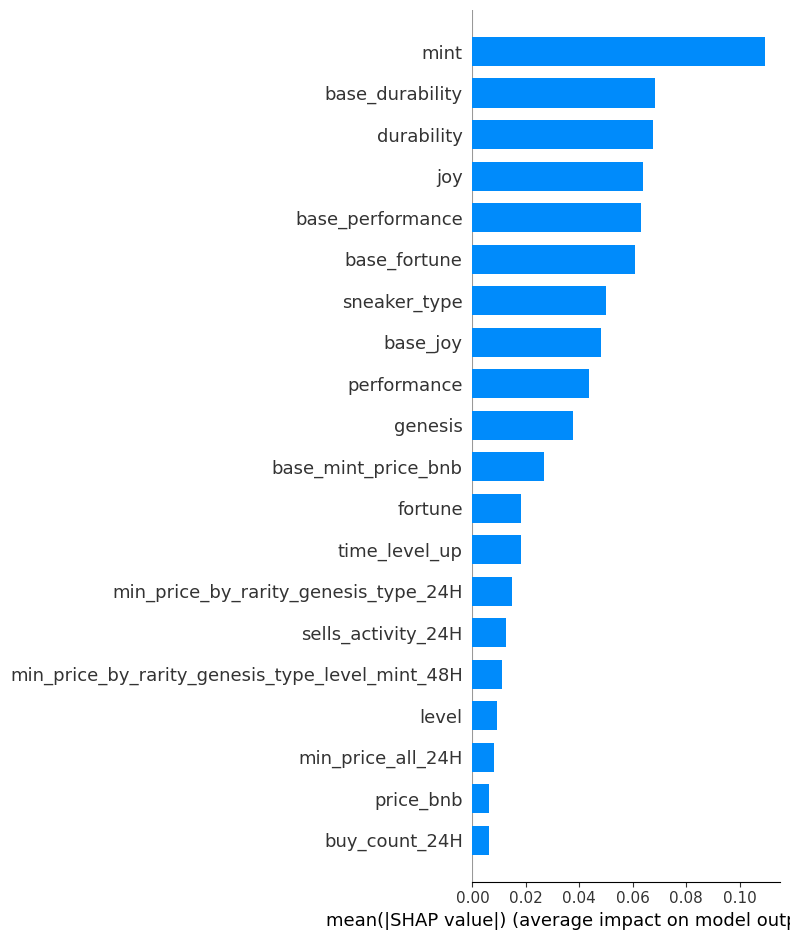

In [70]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## TEST

In [71]:
model = CatBoostRegressor(random_seed=42,)

# Fit model 
model.fit(X_train, y_train, cat_features=cat_features,)
#model.save_model(f'./models/sneaker_model_{VERSION}.model')

Learning rate set to 0.051319
0:	learn: 1.1427605	total: 2.5ms	remaining: 2.5s
1:	learn: 1.0976390	total: 5.68ms	remaining: 2.83s
2:	learn: 1.0565686	total: 8.11ms	remaining: 2.69s
3:	learn: 1.0177132	total: 10.2ms	remaining: 2.55s
4:	learn: 0.9813682	total: 12.1ms	remaining: 2.4s
5:	learn: 0.9467190	total: 13.8ms	remaining: 2.29s
6:	learn: 0.9147760	total: 15.6ms	remaining: 2.21s
7:	learn: 0.8829800	total: 17.4ms	remaining: 2.16s
8:	learn: 0.8539204	total: 19.2ms	remaining: 2.11s
9:	learn: 0.8251924	total: 21ms	remaining: 2.07s
10:	learn: 0.7983135	total: 22.8ms	remaining: 2.05s
11:	learn: 0.7734287	total: 24.6ms	remaining: 2.02s
12:	learn: 0.7519862	total: 26.5ms	remaining: 2.01s
13:	learn: 0.7299748	total: 28.2ms	remaining: 1.99s
14:	learn: 0.7096692	total: 30ms	remaining: 1.97s
15:	learn: 0.6896109	total: 31.6ms	remaining: 1.94s
16:	learn: 0.6694106	total: 35.1ms	remaining: 2.03s
17:	learn: 0.6510687	total: 36.9ms	remaining: 2.01s
18:	learn: 0.6345149	total: 38.6ms	remaining: 1.99s

In [72]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

{'R2': 0.894, 'MAE': 0.108, 'MSE': 0.084, 'RMSE': 0.291, 'MAPE': 0.076}

In [73]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

iteritems is deprecated and will be removed in a future version. Use .items instead.


{'R2': 0.894, 'MAE': 0.108, 'MSE': 0.084, 'RMSE': 0.291, 'MAPE': 0.076}

In [74]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

iteritems is deprecated and will be removed in a future version. Use .items instead.


{'R2': 0.894, 'MAE': 0.108, 'MSE': 0.084, 'RMSE': 0.291, 'MAPE': 0.076}

## Fit full Model

In [75]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

model = CatBoostRegressor(random_seed=42,)

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


Learning rate set to 0.053737
0:	learn: 1.0784661	total: 3.11ms	remaining: 3.11s
1:	learn: 1.0338535	total: 5.91ms	remaining: 2.95s
2:	learn: 0.9929976	total: 8.62ms	remaining: 2.87s
3:	learn: 0.9545327	total: 10.9ms	remaining: 2.7s
4:	learn: 0.9201385	total: 12.8ms	remaining: 2.54s
5:	learn: 0.8857877	total: 14.7ms	remaining: 2.43s
6:	learn: 0.8541680	total: 16.7ms	remaining: 2.37s
7:	learn: 0.8215249	total: 18.3ms	remaining: 2.27s
8:	learn: 0.7926255	total: 20.3ms	remaining: 2.24s
9:	learn: 0.7649398	total: 22.3ms	remaining: 2.21s
10:	learn: 0.7392300	total: 24.3ms	remaining: 2.18s
11:	learn: 0.7131096	total: 26.3ms	remaining: 2.17s
12:	learn: 0.6899251	total: 28.2ms	remaining: 2.14s
13:	learn: 0.6682399	total: 30ms	remaining: 2.12s
14:	learn: 0.6493309	total: 31.8ms	remaining: 2.09s
15:	learn: 0.6310974	total: 33.7ms	remaining: 2.07s
16:	learn: 0.6131541	total: 35.5ms	remaining: 2.05s
17:	learn: 0.5959024	total: 37.4ms	remaining: 2.04s
18:	learn: 0.5790103	total: 39.2ms	remaining: 2

### Test

In [76]:
i=1800

In [77]:
sneaker_dict = {}

features = data.columns

for feature in features:
    sneaker_dict[feature] = data.iloc[i][feature]

sneaker_dict['sum_activity_24H'] = sneaker_dict['buy_count_24H'] + sneaker_dict['sell_count_24H'] + sneaker_dict['cancel_count_24H']
sneaker_dict['sells_activity_24H'] = sneaker_dict['sell_count_24H'] / sneaker_dict['buy_count_24H']

sample = pd.Series(sneaker_dict)
sample[model.feature_names_]

rarity                                                 common
sneaker_type                                           ranger
genesis                                                 False
level                                                       5
base_performance                                          7.7
base_fortune                                              4.1
base_joy                                                  3.9
base_durability                                           9.5
performance                                              26.7
fortune                                                   6.1
joy                                                       5.9
durability                                               14.5
mint                                                      1.0
buy_count_24H                                             319
min_price_all_24H                                         0.7
sells_activity_24H                                   1.824451
min_pric

In [78]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] not in dq[feature]:
        print(f'{feature} not in data_quality_expected_range_dict. get {sneaker_dict[feature]}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] < dq[feature][0]:
        print(f'{feature} less then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][0]}')

    if sneaker_dict[feature] > dq[feature][1]:
        print(f'{feature} more then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][1]}')

In [79]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

sample = pd.Series(sneaker_dict)
predict_price = model.predict(sample[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

0.946

In [80]:
data.iloc[i]['price']

0.85

iteritems is deprecated and will be removed in a future version. Use .items instead.


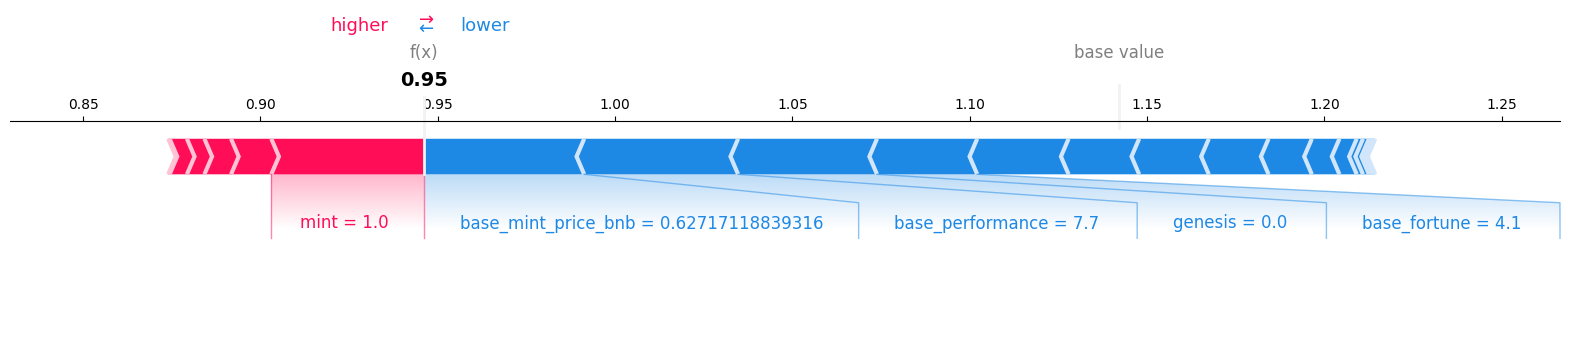

In [81]:
sample = pd.Series(sneaker_dict)
sample = pd.DataFrame(sample[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
#shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)

# Base Model

In [82]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    'level',
    'base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability',
    'mint',
    ]
cat_features = [0, 1, 2]

In [83]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.price.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.price.copy().reset_index(drop=True)

In [84]:
X.genesis.value_counts()

False    4148
True     1442
Name: genesis, dtype: int64

In [85]:
X

,rarity,sneaker_type,genesis,level,base_performance,base_fortune,base_joy,base_durability,performance,fortune,joy,durability,mint
0,common,ranger,False,5,8.0,7.4,5.0,2.5,27.0,10.9,7.5,4.0,0.0
1,common,ranger,False,5,7.8,9.9,6.2,2.5,26.8,14.9,9.2,4.0,0.0
2,common,ranger,False,5,8.0,4.0,2.9,4.9,27.0,6.0,4.4,7.4,2.0
3,common,ranger,False,5,8.3,7.6,1.0,9.6,18.3,20.6,1.5,14.6,2.0
4,common,hiker,True,10,6.3,8.6,9.0,5.1,34.3,17.3,18.0,18.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5585,common,hiker,False,5,7.4,2.5,3.9,4.4,25.9,4.0,5.9,6.4,2.0
5586,common,sprinter,False,5,6.7,4.6,7.1,3.4,25.2,7.1,10.6,4.9,0.0
5587,common,ranger,False,6,1.2,5.0,8.0,1.9,1.8,26.0,12.8,3.1,1.0
5588,common,ranger,False,0,1.6,6.5,7.1,9.8,1.6,6.5,7.1,9.8,0.0


In [86]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     iterations=1000,
    #     learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:01,  1.57s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:03,  1.53s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:04,  1.53s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:06,  1.54s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:07,  1.55s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:09,  1.55s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:10,  1.54s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:12,  1.53s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:13,  1.53s/it]iteritems is deprec

In [87]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.892,0.0683
MAE,0.110,0.0196
MSE,0.167,0.1546
RMSE,0.378,0.1573
MAPE,0.069,0.0043


In [88]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.892,0.0683
MAE,0.110,0.0196
MSE,0.167,0.1546
RMSE,0.378,0.1573
MAPE,0.069,0.0043


In [89]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.881, 'MAE': 0.11, 'MSE': 0.167, 'RMSE': 0.409, 'MAPE': 0.069}

In [90]:
# # Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


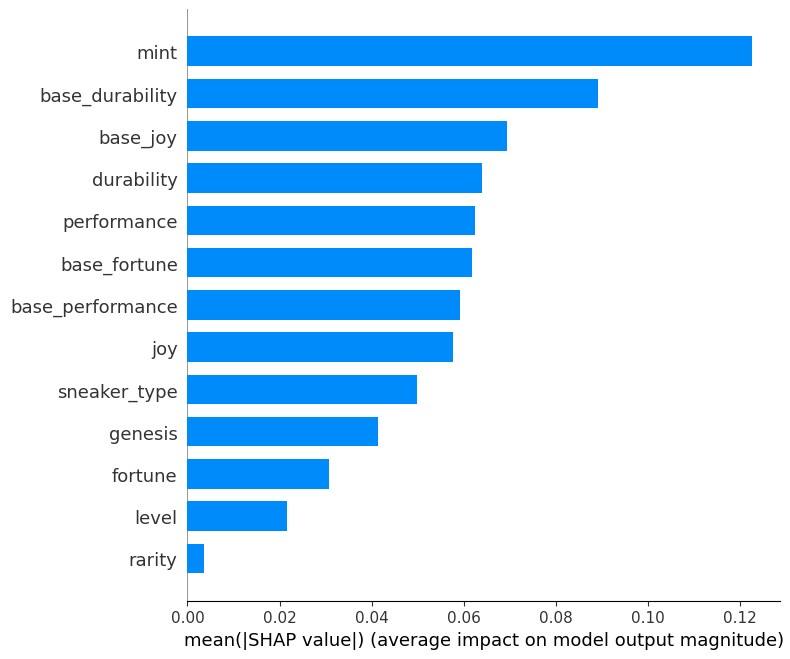

In [91]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

In [92]:
#shap.summary_plot(shap_values, train_x,)

## TEST

In [93]:
model = CatBoostRegressor(random_seed=42,)
model.fit(X_train, y_train, cat_features=cat_features,)

pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

Learning rate set to 0.051319
0:	learn: 1.1410770	total: 2.25ms	remaining: 2.24s
1:	learn: 1.0959801	total: 3.44ms	remaining: 1.72s
2:	learn: 1.0532690	total: 5.35ms	remaining: 1.78s
3:	learn: 1.0154763	total: 7.18ms	remaining: 1.79s
4:	learn: 0.9774763	total: 8.99ms	remaining: 1.79s
5:	learn: 0.9413410	total: 10.7ms	remaining: 1.77s
6:	learn: 0.9119543	total: 12.2ms	remaining: 1.74s
7:	learn: 0.8796819	total: 13.8ms	remaining: 1.71s
8:	learn: 0.8496175	total: 15.4ms	remaining: 1.7s
9:	learn: 0.8208462	total: 16.9ms	remaining: 1.67s
10:	learn: 0.7944913	total: 18.3ms	remaining: 1.65s
11:	learn: 0.7691202	total: 19.9ms	remaining: 1.64s
12:	learn: 0.7443793	total: 21.5ms	remaining: 1.63s
13:	learn: 0.7216350	total: 23ms	remaining: 1.62s
14:	learn: 0.6998806	total: 24.7ms	remaining: 1.62s
15:	learn: 0.6793404	total: 26.2ms	remaining: 1.61s
16:	learn: 0.6602480	total: 27.8ms	remaining: 1.6s
17:	learn: 0.6431439	total: 29.4ms	remaining: 1.6s
18:	learn: 0.6261004	total: 30.4ms	remaining: 1.5

{'R2': 0.898, 'MAE': 0.121, 'MSE': 0.081, 'RMSE': 0.284, 'MAPE': 0.089}

## Fit full Base model

In [94]:
#build model
# model = CatBoostRegressor(
#         loss_function='MAPE',
#         #loss_function='MAE',
#         iterations=1000,
#         learning_rate=0.01,
#         depth=4,
#         #l2_leaf_reg=0.2,
#         #min_child_samples=10,
#         #bagging_temperature=5,
#         random_seed=42,
#     )
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_base_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


Learning rate set to 0.053737
0:	learn: 1.0759173	total: 2.81ms	remaining: 2.81s
1:	learn: 1.0310207	total: 4.82ms	remaining: 2.41s
2:	learn: 0.9923493	total: 7.54ms	remaining: 2.51s
3:	learn: 0.9526507	total: 9.61ms	remaining: 2.39s
4:	learn: 0.9165299	total: 11.6ms	remaining: 2.31s
5:	learn: 0.8819885	total: 13.5ms	remaining: 2.23s
6:	learn: 0.8494235	total: 15.3ms	remaining: 2.17s
7:	learn: 0.8187587	total: 17ms	remaining: 2.11s
8:	learn: 0.7902220	total: 18.7ms	remaining: 2.06s
9:	learn: 0.7628787	total: 22.1ms	remaining: 2.19s
10:	learn: 0.7362923	total: 23.8ms	remaining: 2.14s
11:	learn: 0.7122594	total: 25.7ms	remaining: 2.11s
12:	learn: 0.6897665	total: 27.6ms	remaining: 2.09s
13:	learn: 0.6682817	total: 29.5ms	remaining: 2.08s
14:	learn: 0.6483397	total: 31.2ms	remaining: 2.05s
15:	learn: 0.6295140	total: 32.9ms	remaining: 2.02s
16:	learn: 0.6121456	total: 34.6ms	remaining: 2s
17:	learn: 0.5951854	total: 36.5ms	remaining: 1.99s
18:	learn: 0.5775630	total: 38.3ms	remaining: 1.9

### Test

In [95]:
sneaker_dict = {
    'rarity': 'common',
    'sneaker_type': 'coacher',
    'genesis': True,
    #'genesis': False,
    'level': 19,
    'base_performance': 5.4,
    'base_fortune': 8.1,
    'base_joy': 9.6,
    'base_durability': 8.0,
    'performance': 71.9,
    'fortune': 23.3,
    'joy': 28.1,
    'durability': 23.2,
    #'condition': 100,
    'mint': 2,
}

In [96]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(pd.Series(sneaker_dict)[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

2.38

iteritems is deprecated and will be removed in a future version. Use .items instead.


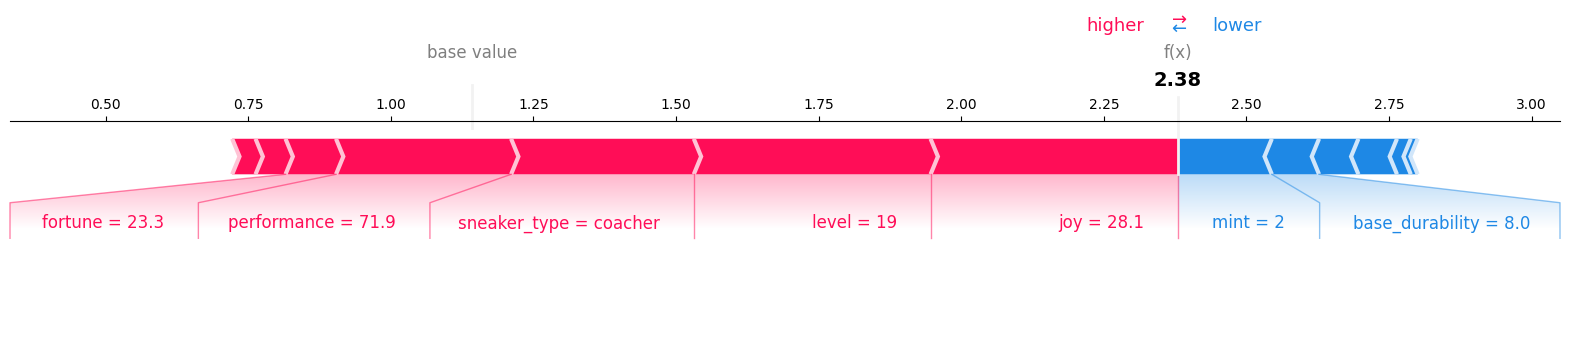

In [97]:
sample = pd.DataFrame(pd.Series(sneaker_dict)[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)

iteritems is deprecated and will be removed in a future version. Use .items instead.


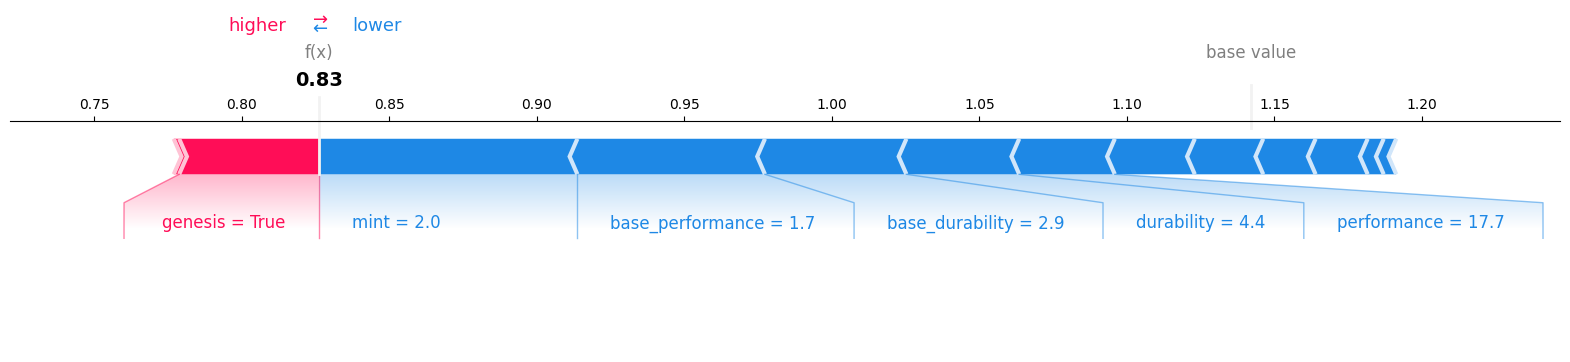

In [98]:
sample = data[data['token_id'] == 20928][model.feature_names_][:1]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)
#plt.savefig(f'explainer_{VERSION}.png', dpi=700)
#plt.show()

In [99]:
#shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=False, matplotlib=True).savefig(f'sneaker_base_model_explainer_img.png', format = "png", dpi = 150, bbox_inches = 'tight')

# Box Model

## Data

In [100]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')

In [101]:
#data.genesis = data.genesis.fillna(0).astype(int).astype(bool)

In [102]:
data = data[(data.item_type == 'box') & (data.event == 'buy')].copy().reset_index(drop=True)
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
0,1663773110,35428,54943,buy,0x77da0f6c830831b4205f901dba2b247881cc4af9,0x57f815c6e50ca3914abbdf57a302789beb932d99,1.08,box,common,NaN,...,425.0,8268.0,774,0,343,3021,6014,10601,92.0,1.243902
1,1663767791,35794,55212,buy,0x34ed17aa39ed78167318a549b70af9c1357ffcde,0x57f815c6e50ca3914abbdf57a302789beb932d99,1.07,box,common,NaN,...,414.0,8261.0,792,0,431,3039,6028,10645,93.0,1.268293
2,1663765268,35779,55206,buy,0xf3872b3c3ee2eda629566f18c8425695b8ac7375,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,1.02,box,common,NaN,...,413.0,8259.0,790,0,446,3040,6025,10641,91.0,1.219512
3,1663761263,35569,54842,buy,0x7a4c0c70e5c7713c9ccec9e06165cf6cd3b95745,0x57f815c6e50ca3914abbdf57a302789beb932d99,1.05,box,common,NaN,...,386.0,8259.0,784,0,410,3000,5985,10600,88.0,1.146341
4,1663758803,35639,55048,buy,0x60a823e85593e707850aa5fabc87ab6d50781df5,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,1.04,box,common,NaN,...,378.0,8256.0,780,0,405,2994,5978,10588,87.0,1.121951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,1661070301,13989,33249,buy,0x3869363159f953feed0959fc23e32f60d784b249,0xf2e2a51537fac7b62234c57e1ef35c6dc35536d1,0.89,box,common,NaN,...,NaN,NaN,905,0,397,1702,2056,2549,NaN,NaN
899,1661054035,13521,227,buy,0xfbe5e186feacd47fedfbc91e4c9b0c64db928784,0xd5da766c451b21ab962e99a34675102dd96eaab6,1.50,box,common,NaN,...,NaN,NaN,904,0,388,1664,2002,2492,NaN,NaN
900,1661034370,13747,32215,buy,0x07a42ed43e24b0d23fe6b347378ccdac7c448397,0x5e56fc61fc07cba1367e8bccb0ef919116c71d74,0.98,box,common,NaN,...,NaN,NaN,903,0,253,1505,1844,2328,NaN,NaN
901,1661033512,13544,32564,buy,0x560e7af378e08e0681e0df3cda652078a6c3cdb9,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0.95,box,common,NaN,...,NaN,NaN,904,0,249,1502,1840,2324,NaN,NaN


In [103]:
data = data[((~data['parent1_sneaker_type'].isna() & (~data['parent2_sneaker_type'].isna())) | (data['genesis']))].copy().reset_index(drop=True)

In [104]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

In [105]:
len(data)

903

In [106]:
len(data[data.date >= START_DATE])

537

In [107]:
data = data[data.date >= START_DATE].reset_index(drop=True).copy()

In [108]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
0,1.659602e+09,6978.0,6.0,6.0,NaN,1800.0,300.0,200.0,0.676773
1,1.657800e+09,11145.0,8.0,6.0,NaN,1800.0,300.0,200.0,0.676012
2,1.657800e+09,23229.0,6.0,4.0,NaN,1800.0,300.0,200.0,0.677113
3,1.657802e+09,21564.0,6.0,5.0,NaN,1800.0,300.0,200.0,0.639683
4,1.657801e+09,38277.0,8.0,3.0,NaN,1800.0,300.0,200.0,0.642806
...,...,...,...,...,...,...,...,...,...
532,1.657809e+09,2456.0,13.0,10.0,NaN,1800.0,300.0,200.0,0.660533
533,1.660109e+09,11864.0,6.0,5.0,NaN,1800.0,300.0,200.0,0.648571
534,1.659431e+09,192.0,2.0,1.0,NaN,1800.0,300.0,200.0,0.646019
535,1.657800e+09,2010.0,8.0,6.0,NaN,1800.0,300.0,200.0,0.653796


In [109]:
data[['timestamp', 'mrk_id', 'token_id', 'event', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type', 'date']]

,timestamp,mrk_id,token_id,event,genesis,parent1_sneaker_type,parent2_sneaker_type,date
0,1662164401,21798,40436,buy,False,hiker,hiker,2022-09-03 00:20:01
1,1662170890,21796,40464,buy,False,hiker,sprinter,2022-09-03 02:08:10
2,1662171007,21614,38512,buy,False,coacher,coacher,2022-09-03 02:10:07
3,1662181762,21801,40467,buy,False,ranger,ranger,2022-09-03 05:09:22
4,1662186301,21623,38529,buy,False,coacher,coacher,2022-09-03 06:25:01
...,...,...,...,...,...,...,...,...
532,1663758803,35639,55048,buy,False,hiker,ranger,2022-09-21 11:13:23
533,1663761263,35569,54842,buy,False,hiker,sprinter,2022-09-21 11:54:23
534,1663765268,35779,55206,buy,False,ranger,ranger,2022-09-21 13:01:08
535,1663767791,35794,55212,buy,False,sprinter,hiker,2022-09-21 13:43:11


In [110]:
data.genesis.value_counts()

False    496
True      41
Name: genesis, dtype: int64

In [111]:
sneaker_types = ['ranger', 'sprinter', 'hiker', 'coacher']

In [112]:
from itertools import combinations
sneaker_combs = list(combinations(sneaker_types, 2))

In [113]:
comb_features = []

for sneaker_comb in sneaker_combs:
    #print(sneaker_comb[0])
    feature_name = f'{sneaker_comb[0]}_{sneaker_comb[1]}'
    data[feature_name] = (((data['parent1_sneaker_type'] == sneaker_comb[0]) & (data['parent2_sneaker_type'] == sneaker_comb[1])) | ((data['parent1_sneaker_type'] == sneaker_comb[1]) & (data['parent2_sneaker_type'] == sneaker_comb[0])))
    data[feature_name] = data[feature_name].astype(int)
    comb_features.append(feature_name)
    #break

for sneaker_type in sneaker_types:
    feature_name = f'{sneaker_type}_{sneaker_type}'
    data[feature_name] = ((data['parent1_sneaker_type'] == sneaker_type) & (data['parent2_sneaker_type'] == sneaker_type))
    data[feature_name] = data[feature_name].astype(int)
    comb_features.append(feature_name)

In [114]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,ranger_sprinter,ranger_hiker,ranger_coacher,sprinter_hiker,sprinter_coacher,hiker_coacher,ranger_ranger,sprinter_sprinter,hiker_hiker,coacher_coacher
0,1662164401,21798,40436,buy,0xc57ca482a3e1d0eef363166295962163b2f64ed0,0x710b6677ea43dc7cbf513248b896a6f28171b709,1.13,box,common,NaN,...,0,0,0,0,0,0,0,0,1,0
1,1662170890,21796,40464,buy,0xf7b7c0f111fe7bf762fc2c706aee194a39758e95,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,1.13,box,common,NaN,...,0,0,0,1,0,0,0,0,0,0
2,1662171007,21614,38512,buy,0x2a3f0c8349bde254599ed019a2d1994de06b7803,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,1.18,box,common,NaN,...,0,0,0,0,0,0,0,0,0,1
3,1662181762,21801,40467,buy,0x80dd92e3473e45c935edce170191810dc93bc56b,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,1.09,box,common,NaN,...,0,0,0,0,0,0,1,0,0,0
4,1662186301,21623,38529,buy,0x50975867d5c0bad1b78ebf4b06252be9bdb76c64,0x741d48c325f4d29e9961cc86239a96070b3a1f4e,1.20,box,common,NaN,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532,1663758803,35639,55048,buy,0x60a823e85593e707850aa5fabc87ab6d50781df5,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,1.04,box,common,NaN,...,0,1,0,0,0,0,0,0,0,0
533,1663761263,35569,54842,buy,0x7a4c0c70e5c7713c9ccec9e06165cf6cd3b95745,0x57f815c6e50ca3914abbdf57a302789beb932d99,1.05,box,common,NaN,...,0,0,0,1,0,0,0,0,0,0
534,1663765268,35779,55206,buy,0xf3872b3c3ee2eda629566f18c8425695b8ac7375,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,1.02,box,common,NaN,...,0,0,0,0,0,0,1,0,0,0
535,1663767791,35794,55212,buy,0x34ed17aa39ed78167318a549b70af9c1357ffcde,0x57f815c6e50ca3914abbdf57a302789beb932d99,1.07,box,common,NaN,...,0,0,0,1,0,0,0,0,0,0


In [115]:
comb_features

['ranger_sprinter',
 'ranger_hiker',
 'ranger_coacher',
 'sprinter_hiker',
 'sprinter_coacher',
 'hiker_coacher',
 'ranger_ranger',
 'sprinter_sprinter',
 'hiker_hiker',
 'coacher_coacher']

In [116]:
data['ranger_hiker'].sum()

55

## FE

In [117]:
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']
data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']

# Model

In [118]:
features = [
    'rarity', 
    'genesis',
    'buy_count_12H',
    'buy_count_24H',
    'sum_activity_24H',
    'sells_activity_24H',
    'min_price_all_24H',
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    #'base_mint_price_bnb',
    'price_bnb', 
    #'price_azy', 
    #'price_amt',
    #'wallet_from_buy_count',
    #'wallet_from_all_count', 
    *comb_features
    ]
cat_columns = ['rarity',]
cat_features = [0,]

In [119]:
X = data[features].reset_index(drop=True).copy()
y = data.price.reset_index(drop=True).copy()

In [120]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X, y)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    val_x, val_y = X.iloc[valid_idx], y.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     #iterations=1000,
    #     #learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # Fit model 
    model.fit(#train_data,
        train_x, 
        train_y,
        #eval_set=(X_test, y_test),
        cat_features=cat_features,
        #plot=True,
        verbose=False,
        )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  1.94it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:01,  1.94it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:01,  1.97it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:02,  1.98it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:02,  1.98it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:03,  1.98it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:03,  1.98it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:04,  1.98it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:04,  1.98it/s]iteritems is deprec

In [121]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.921,0.0566
MAE,0.058,0.0107
MSE,0.012,0.0057
RMSE,0.106,0.0273
MAPE,0.045,0.0068


In [122]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.921,0.0566
MAE,0.058,0.0107
MSE,0.012,0.0057
RMSE,0.106,0.0273
MAPE,0.045,0.0068


In [123]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.942, 'MAE': 0.058, 'MSE': 0.012, 'RMSE': 0.109, 'MAPE': 0.045}

iteritems is deprecated and will be removed in a future version. Use .items instead.


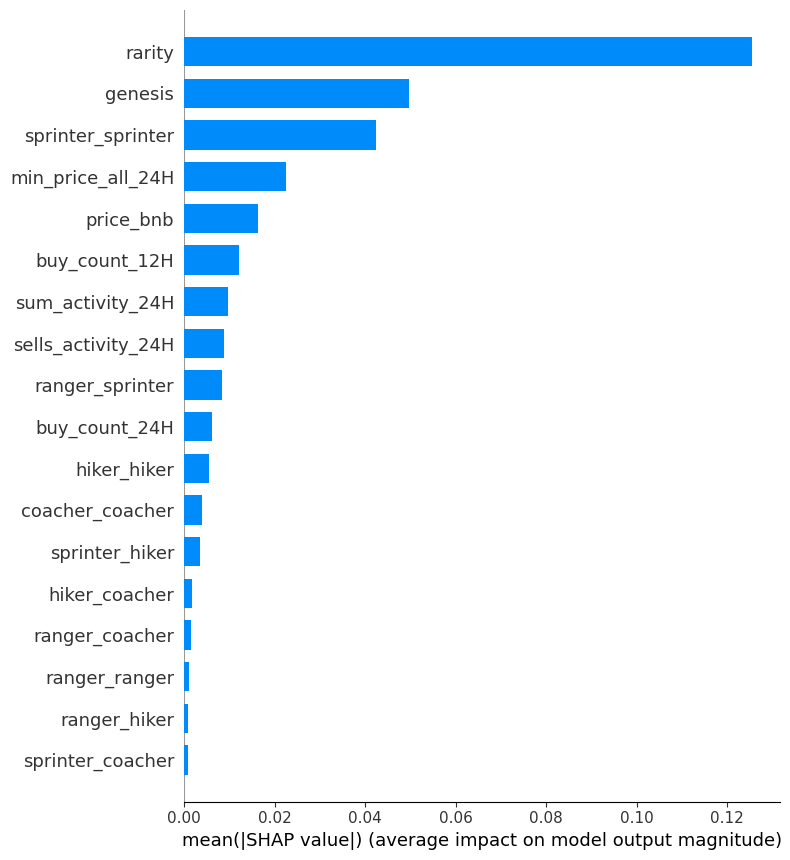

In [124]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar',)

## Fit Box Model on full data

In [125]:
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/box_model_{VERSION}.model')

Learning rate set to 0.037112
0:	learn: 0.4464151	total: 792us	remaining: 792ms
1:	learn: 0.4376482	total: 1.65ms	remaining: 825ms
2:	learn: 0.4261028	total: 2.39ms	remaining: 793ms
3:	learn: 0.4144381	total: 2.79ms	remaining: 694ms
4:	learn: 0.4051542	total: 3.52ms	remaining: 700ms
5:	learn: 0.3932902	total: 3.9ms	remaining: 646ms
6:	learn: 0.3828831	total: 4.4ms	remaining: 624ms
7:	learn: 0.3726948	total: 4.6ms	remaining: 571ms
8:	learn: 0.3639786	total: 5.34ms	remaining: 588ms
9:	learn: 0.3564634	total: 6.08ms	remaining: 602ms
10:	learn: 0.3482253	total: 6.37ms	remaining: 573ms
11:	learn: 0.3394015	total: 6.92ms	remaining: 570ms
12:	learn: 0.3317677	total: 7.27ms	remaining: 552ms
13:	learn: 0.3259188	total: 7.94ms	remaining: 559ms
14:	learn: 0.3184082	total: 8.19ms	remaining: 538ms
15:	learn: 0.3105973	total: 8.62ms	remaining: 530ms
16:	learn: 0.3036088	total: 8.87ms	remaining: 513ms
17:	learn: 0.2956638	total: 9.44ms	remaining: 515ms
18:	learn: 0.2884486	total: 9.68ms	remaining: 50

### Test

In [126]:
i = 250

In [127]:
box_dict = {}

features = data.columns

for feature in features:
    box_dict[feature] = data.iloc[i][feature]

box_dict['sum_activity_24H'] = box_dict['buy_count_24H'] + box_dict['sell_count_24H'] + box_dict['cancel_count_24H']
box_dict['sells_activity_24H'] = box_dict['sell_count_24H'] / box_dict['buy_count_24H']

box_dict

{'timestamp': 1662994885,
 'mrk_id': 27361,
 'token_id': 47029,
 'event': 'buy',
 'wallet_from': '0x0885157dbb0db47f63477b1d88c62a8b5193aefa',
 'wallet_to': '0xf06301c9b159e20d019995b4943f075b6b28e246',
 'price': 1.0,
 'item_type': 'box',
 'rarity': 'common',
 'sneaker_type': nan,
 'level': 0,
 'base_performance': nan,
 'base_fortune': nan,
 'base_joy': nan,
 'base_durability': nan,
 'performance': nan,
 'fortune': nan,
 'joy': nan,
 'durability': nan,
 'mint': nan,
 'parent1': 19505.0,
 'parent2': 19511.0,
 'genesis': False,
 'parent1_sneaker_type': 'ranger',
 'parent2_sneaker_type': 'sprinter',
 'price_bnb': 297.38936778,
 'price_azy': 0.09238833,
 'price_amt': 0.55592094,
 'wallet_from_buy_count': 2,
 'wallet_from_all_count': 9,
 'token_all_activity_3H': 0,
 'token_sell_activity_6H': 0,
 'buy_count_12H': 16,
 'buy_count_24H': 25,
 'buy_count_48H': 55,
 'sell_count_12H': 18,
 'sell_count_24H': 40,
 'sell_count_48H': 96,
 'cancel_count_12H': 9,
 'cancel_count_24H': 24,
 'cancel_count_

In [128]:
template_data = pd.Series(index = model.feature_names_, dtype='int64')

template_data['rarity'] = box_dict['rarity']
template_data['genesis'] = box_dict['genesis']
template_data['buy_count_12H'] = box_dict['buy_count_12H']
template_data['buy_count_24H'] = box_dict['buy_count_24H']
template_data['sells_activity_24H'] = box_dict['sells_activity_24H']
template_data['sum_activity_24H'] = box_dict['sum_activity_24H']
template_data['min_price_all_24H'] = box_dict['min_price_all_24H']
template_data['wallet_from_buy_count'] = box_dict['wallet_from_buy_count']
template_data['wallet_from_all_count'] = box_dict['wallet_from_all_count']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"

    template_data[feature_name] = 1

template_data

rarity                   common
genesis                   False
buy_count_12H                16
buy_count_24H                25
sum_activity_24H             89
sells_activity_24H          1.6
min_price_all_24H           0.9
price_bnb                   NaN
ranger_sprinter               1
ranger_hiker                NaN
ranger_coacher              NaN
sprinter_hiker              NaN
sprinter_coacher            NaN
hiker_coacher               NaN
ranger_ranger               NaN
sprinter_sprinter           NaN
hiker_hiker                 NaN
coacher_coacher             NaN
wallet_from_buy_count         2
wallet_from_all_count         9
dtype: object

In [129]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

1.029

In [130]:
data.iloc[i]['price']

1.0

In [131]:
template_data['genesis'] = True

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

1.41

In [132]:
template_data['rarity'] = 'uncommon'

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

2.16

# Box Base Model

In [133]:
features = ['rarity', 'genesis', *comb_features]
cat_columns = ['rarity',]
cat_features = [0,]

In [134]:
features

['rarity',
 'genesis',
 'ranger_sprinter',
 'ranger_hiker',
 'ranger_coacher',
 'sprinter_hiker',
 'sprinter_coacher',
 'hiker_coacher',
 'ranger_ranger',
 'sprinter_sprinter',
 'hiker_hiker',
 'coacher_coacher']

In [135]:
X = data[features].reset_index(drop=True).copy()
y = data.price.reset_index(drop=True).copy()

In [136]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rarity             537 non-null    object
 1   genesis            537 non-null    bool  
 2   ranger_sprinter    537 non-null    int64 
 3   ranger_hiker       537 non-null    int64 
 4   ranger_coacher     537 non-null    int64 
 5   sprinter_hiker     537 non-null    int64 
 6   sprinter_coacher   537 non-null    int64 
 7   hiker_coacher      537 non-null    int64 
 8   ranger_ranger      537 non-null    int64 
 9   sprinter_sprinter  537 non-null    int64 
 10  hiker_hiker        537 non-null    int64 
 11  coacher_coacher    537 non-null    int64 
dtypes: bool(1), int64(10), object(1)
memory usage: 46.8+ KB


In [137]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X, y)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    val_x, val_y = X.iloc[valid_idx], y.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     #iterations=1000,
    #     #learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # train_data = Pool(
    #     train_x, 
    #     train_y,
    #     cat_features=cat_features,
    #     )

    # Fit model 
    model.fit(#train_data,
        train_x, 
        train_y,
        #eval_set=(X_test, y_test),
        cat_features=cat_features,
        #plot=True,
        verbose=False,
        )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  4.64it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:00,  4.59it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:00,  4.66it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:00,  4.72it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:01,  4.67it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:01,  4.71it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:01,  4.69it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:01,  4.70it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:01,  4.72it/s]iteritems is deprec

In [138]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.904,0.0577
MAE,0.075,0.0155
MSE,0.016,0.0105
RMSE,0.122,0.0391
MAPE,0.059,0.0070


In [139]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.904,0.0577
MAE,0.075,0.0155
MSE,0.016,0.0105
RMSE,0.122,0.0391
MAPE,0.059,0.0070


In [140]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.921, 'MAE': 0.075, 'MSE': 0.016, 'RMSE': 0.128, 'MAPE': 0.059}

iteritems is deprecated and will be removed in a future version. Use .items instead.


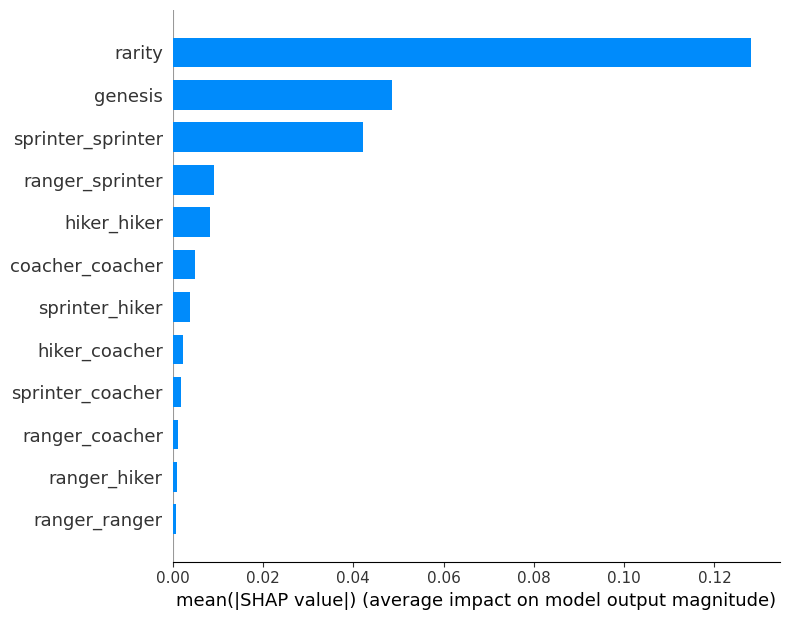

In [141]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## Fit on full data

In [142]:
#build model
# model = CatBoostRegressor(
#         loss_function='MAPE',
#         #loss_function='MAE',
#         #iterations=1000,
#         #learning_rate=0.01,
#         depth=4,
#         #l2_leaf_reg=0.2,
#         #min_child_samples=10,
#         #bagging_temperature=5,
#         random_seed=42,
#     )
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/box_base_model_{VERSION}.model')

Learning rate set to 0.037112
0:	learn: 0.4417726	total: 177us	remaining: 177ms
1:	learn: 0.4296433	total: 276us	remaining: 138ms
2:	learn: 0.4179586	total: 371us	remaining: 123ms
3:	learn: 0.4057021	total: 489us	remaining: 122ms
4:	learn: 0.3947804	total: 601us	remaining: 120ms
5:	learn: 0.3843228	total: 690us	remaining: 114ms
6:	learn: 0.3742587	total: 771us	remaining: 109ms
7:	learn: 0.3635355	total: 887us	remaining: 110ms
8:	learn: 0.3541964	total: 1.14ms	remaining: 126ms
9:	learn: 0.3452161	total: 1.32ms	remaining: 131ms
10:	learn: 0.3365838	total: 1.49ms	remaining: 134ms
11:	learn: 0.3277650	total: 1.77ms	remaining: 146ms
12:	learn: 0.3197419	total: 1.94ms	remaining: 147ms
13:	learn: 0.3120366	total: 2.1ms	remaining: 148ms
14:	learn: 0.3045009	total: 2.29ms	remaining: 151ms
15:	learn: 0.2972171	total: 2.58ms	remaining: 158ms
16:	learn: 0.2891655	total: 2.82ms	remaining: 163ms
17:	learn: 0.2832782	total: 3.01ms	remaining: 164ms
18:	learn: 0.2768666	total: 3.15ms	remaining: 163ms
1

## Test

In [143]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

2.411

In [144]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'sprinter',
}

In [145]:
template_data = pd.Series(index = model.feature_names_, dtype='int64')
template_data['rarity'] = box_dict['rarity']
template_data['genesis'] = box_dict['genesis']

template_data

rarity               common
genesis               False
ranger_sprinter         NaN
ranger_hiker            NaN
ranger_coacher          NaN
sprinter_hiker          NaN
sprinter_coacher        NaN
hiker_coacher           NaN
ranger_ranger           NaN
sprinter_sprinter       NaN
hiker_hiker             NaN
coacher_coacher         NaN
dtype: object

In [146]:
if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"

    template_data[feature_name] = 1

template_data

rarity               common
genesis               False
ranger_sprinter         NaN
ranger_hiker            NaN
ranger_coacher          NaN
sprinter_hiker            1
sprinter_coacher        NaN
hiker_coacher           NaN
ranger_ranger           NaN
sprinter_sprinter       NaN
hiker_hiker             NaN
coacher_coacher         NaN
dtype: object

In [147]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

1.059

In [148]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'coacher',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.188

In [149]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'coacher',
    'parent2_sneaker_type': 'hiker',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.188

In [150]:
box_dict = {
    'rarity': 'common',
    'genesis': True,
    'parent1_sneaker_type': '',
    'parent2_sneaker_type': '',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.467

In [151]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'hiker',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.125

In [152]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'ranger',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.084

фитчи из блока:
- маркер перекупа
- количество кроссов у продающего
- базовые хорактеристики
- разницу между базовыми
- сорость прошлой покупки
- количество перепродаж
- количество перевыставлений
- сколько времени весит на маркете кросс
- время выставления
- время после последнего апдейта цены
- количество обновлений цены (одним владельцем)
- окупаемость 
- количество транзакций на кросовке
- количество минта на акке продавца
- когда начал работать продовец с ази
- прошлая цена продажи (и их разница)
- время владения кроссом одним продавцом


Данные по рынку:
- количество транзакций на токене
- количество ордеров (бай, селл, кансел)
- количество ордеров за периоды (бай, селл, кансел)
- разница среднего количества ордеров за период и текущего за день.
- количество холдеров
- количество кроссовок вообще
- количество новых кросовок за периоды (день, 3 дня, неделя и тд)
- количество кроссовок сейчас на рынке
- разница от всего кроссов и сейчас на рынке
- цена токена атм
- цена токена azy
- цена бнб и битка
- изменение цены бнб и битка
- изменение соотношения генезис кроссов к обычным
- изменение соотношения по классам
- цены на боксы
- количество боксов на рынке
- количество кроссов/боксы
- стоимость минта
- прибыльность минта 
- день недели # 7 мин
- выходные # 7 мин
- средние цены кроссов 0 уровня по типам за периоды # 30 мин

внешние данные:
- количество подпищеков в телеге твите



In [153]:
# import ast
# import json

In [154]:
# json_data = "{'token_id': 22259, 'rarity': 'common', 'sneaker_type': 'hiker', 'genesis': False, 'level': 5, 'base_performance': 3.0, 'base_fortune': 2.7, 'base_joy': 7.3, 'base_durability': 3.5, 'performance': 16.5, 'fortune': 4.2, 'joy': 10.8, 'durability': 8.5, 'mint': 2, 'wallet_from_buy_count': 0, 'wallet_from_all_count': 1, 'buy_count_12H': 97, 'buy_count_24H': 191, 'sell_count_24H': 430, 'cancel_count_24H': 238, 'min_price_all_24H': 0.6, 'min_price_by_rarity_genesis_type_level_mint_24H': 0.7, 'min_price_by_rarity_genesis_type_24H': 0.7, 'token_all_activity_3H': 1, 'token_sell_activity_6H': 1, 'explain_models': True}"
# json_data = ast.literal_eval(json_data)

In [155]:
# print(json.dumps(json_data))

In [156]:
# import requests

# r = requests.post(
#     "http://65.21.94.236:8003/sneaker_predict_price", 
#     data=json.dumps(json_data))
# print(r.status_code, r.reason)

In [157]:
#output = json.loads(r.text)

In [158]:
# from PIL import Image
# import base64
# import io 

# im = Image.open(io.BytesIO(base64.b64decode(output['sneaker_model_predict_explain_img'])))
# im.show()

групировку делать по sell оредерам